In [9]:
# import data science relevent libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [10]:
df = pd.read_csv("../data/raw/train.csv")

In [11]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122265 entries, 0 to 122264
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   row_id                 122265 non-null  object 
 1   cfips                  122265 non-null  int64  
 2   county                 122265 non-null  object 
 3   state                  122265 non-null  object 
 4   first_day_of_month     122265 non-null  object 
 5   microbusiness_density  122265 non-null  float64
 6   active                 122265 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 6.5+ MB


### We get quarterly microdensities

In [13]:
df["first_day_of_month"].unique()

array(['2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
       '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
       '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
       '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
       '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
       '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
       '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01'], dtype=object)

In [14]:
# count missing values per column
print(f"mising values per column:\n{df.isnull().sum()}\n")
print(f"Count of values per column:\n{df.count()}")

mising values per column:
row_id                   0
cfips                    0
county                   0
state                    0
first_day_of_month       0
microbusiness_density    0
active                   0
dtype: int64

Count of values per column:
row_id                   122265
cfips                    122265
county                   122265
state                    122265
first_day_of_month       122265
microbusiness_density    122265
active                   122265
dtype: int64


### Unique counties

In [15]:
df["county"].unique().shape

(1871,)

## Size distribution of counties
mostly to understand if we want to use all of them or just the highest populated

In [16]:
c_pop = pd.read_csv(
    "../data/raw/population_counties.csv",
    encoding="latin-1",
    usecols=[
        "REGION",
        "DIVISION",
        "STATE",
        "COUNTY",
        "STNAME",
        "CTYNAME",
        "POPESTIMATE2020",
        "POPESTIMATE2021",
    ],
)
c_pop.columns

Index(['REGION', 'DIVISION', 'STATE', 'COUNTY', 'STNAME', 'CTYNAME',
       'POPESTIMATE2020', 'POPESTIMATE2021'],
      dtype='object')

### Transform to cfips

In [17]:
c_pop["cfips"] = c_pop["STATE"] * 1000 + c_pop["COUNTY"]

In [18]:
c_pop.drop(columns=["STATE", "COUNTY", "DIVISION", "REGION"], inplace=True)
c_pop.head()

,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,cfips
0,Alabama,Alabama,5024803,5039877,1000
1,Alabama,Autauga County,58877,59095,1001
2,Alabama,Baldwin County,233140,239294,1003
3,Alabama,Barbour County,25180,24964,1005
4,Alabama,Bibb County,22223,22477,1007


In [19]:
# merge train data with population data
df = df.merge(c_pop, how="left", left_on="cfips", right_on="cfips")

In [20]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095


In [21]:
# add year column based on first_day_of_month
df["year"] = df["first_day_of_month"].str[:4].astype(int)

### Plot county population distribution 2020

In [22]:
# build a df called df_2020 with only values for 2020
df_2020 = df[df["year"] == 2020].copy()
# only 1 row per county with the latest for each column
df_2020 = (
    df_2020.groupby(["cfips", "county", "state", "STNAME", "CTYNAME"])
    .last()
    .reset_index()
)
df_2020.head()

,cfips,county,state,STNAME,CTYNAME,row_id,first_day_of_month,microbusiness_density,active,POPESTIMATE2020,POPESTIMATE2021,year
0,1001,Autauga County,Alabama,Alabama,Autauga County,1001_2020-12-01,2020-12-01,3.002558,1256,58877,59095,2020
1,1003,Baldwin County,Alabama,Alabama,Baldwin County,1003_2020-12-01,2020-12-01,8.224466,13359,233140,239294,2020
2,1005,Barbour County,Alabama,Alabama,Barbour County,1005_2020-12-01,2020-12-01,1.032144,210,25180,24964,2020
3,1007,Bibb County,Alabama,Alabama,Bibb County,1007_2020-12-01,2020-12-01,1.309604,234,22223,22477,2020
4,1009,Blount County,Alabama,Alabama,Blount County,1009_2020-12-01,2020-12-01,1.613962,713,59081,59041,2020


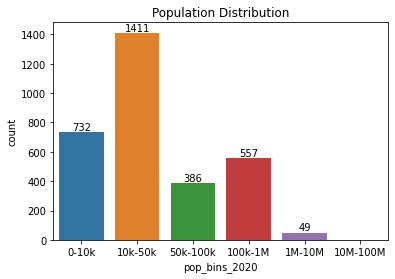

In [23]:
# create bins for POPESTIMATE2020
df_2020["pop_bins_2020"] = pd.cut(
    df_2020["POPESTIMATE2020"],
    bins=[0, 10000, 50000, 100000, 1000000, 10000000, 100000000],
    labels=["0-10k", "10k-50k", "50k-100k", "100k-1M", "1M-10M", "10M-100M"],
)

# plot the distribution of the bins
sns.countplot(x="pop_bins_2020", data=df_2020)
plt.title("Population Distribution")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.show()

### Population reflection
We have many counties that have smaller populations, however these counties might have noisy data. lets explore this

## Explore noise based on population

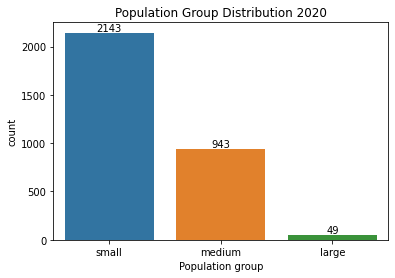

In [24]:
# divide the data into 3 groups based on the population bins, smaller than 50k small, between 50k and 1M medium, and larger than 1M large
df_2020["pop_group_2020"] = pd.cut(
    df_2020["POPESTIMATE2020"],
    bins=[0, 50000, 1000000, 100000000],
    labels=["small", "medium", "large"],
)
# plot the distribution of the groups
sns.countplot(x="pop_group_2020", data=df_2020)
plt.title("Population Group Distribution 2020")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.xlabel("Population group")
plt.show()

In [25]:
df_2020_small = df_2020[df_2020["pop_group_2020"] == "small"]
df_2020_meadium = df_2020[df_2020["pop_group_2020"] == "medium"]
df_2020_large = df_2020[df_2020["pop_group_2020"] == "large"]

<AxesSubplot:xlabel='microbusiness_density', ylabel='Density'>

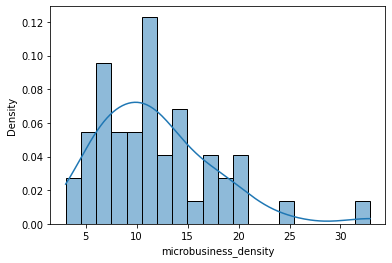

In [26]:
# plot microbusiness density for large counties
sns.histplot(
    x="microbusiness_density",
    data=df_2020_large,
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)

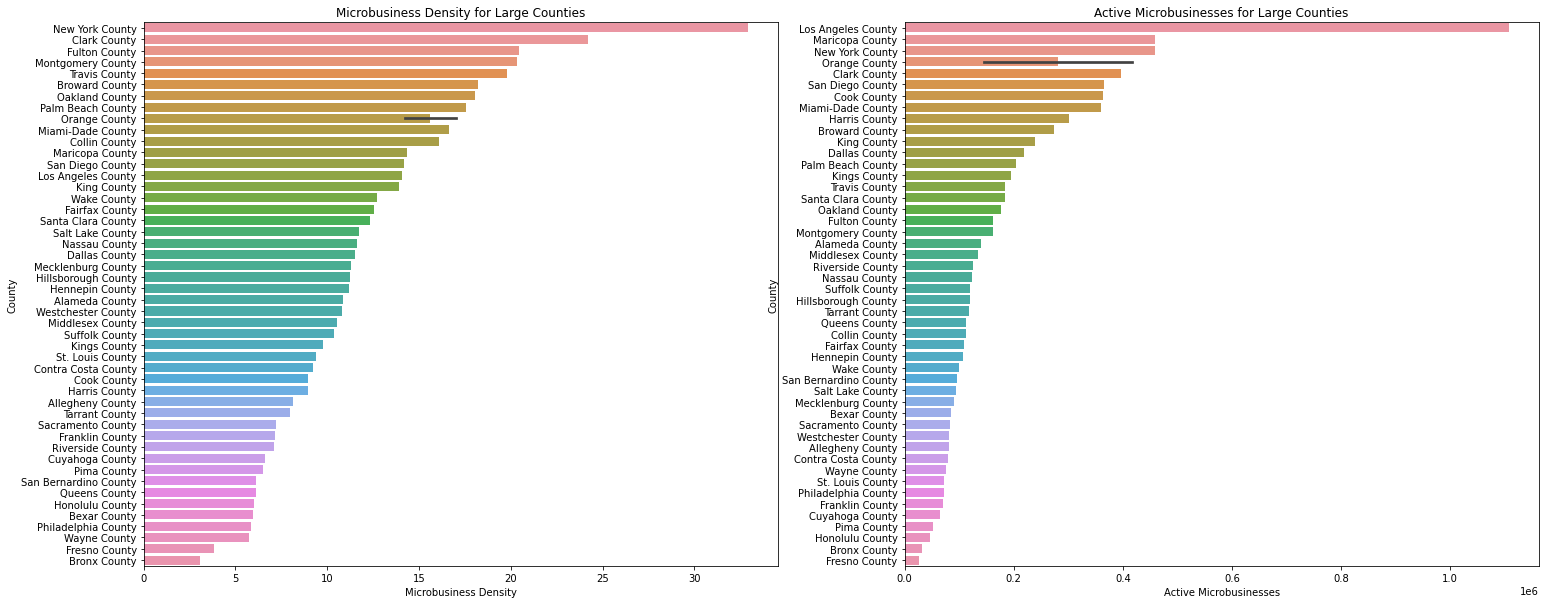

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))
sns.barplot(
    x="microbusiness_density",
    y="CTYNAME",
    data=df_2020_large.sort_values("microbusiness_density", ascending=False),
    ax=ax[0],
)
ax[0].set_title("Microbusiness Density for Large Counties")
ax[0].set_xlabel("Microbusiness Density")
ax[0].set_ylabel("County")
sns.barplot(
    x="active",
    y="CTYNAME",
    data=df_2020_large.sort_values("active", ascending=False),
    ax=ax[1],
)
ax[1].set_title("Active Microbusinesses for Large Counties")
ax[1].set_xlabel("Active Microbusinesses")
ax[1].set_ylabel("County")
plt.show()

### In order to compare the three we can compare the distribution of microbussiness density of the 3

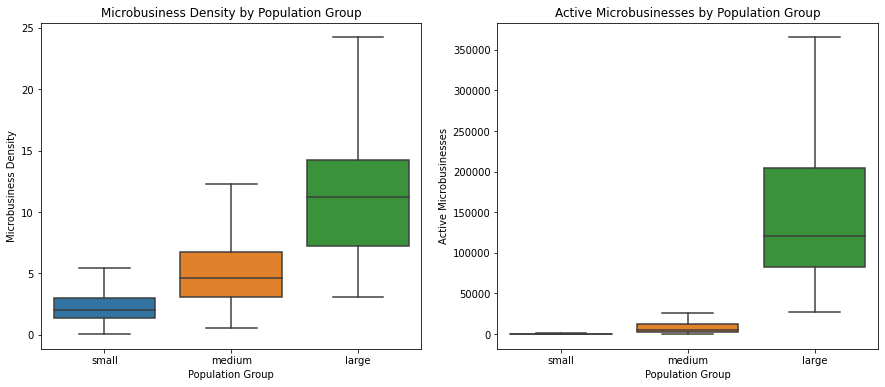

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(
    x="pop_group_2020",
    y="microbusiness_density",
    data=df_2020,
    showfliers=False,
    ax=ax[0],
)
ax[0].set_title("Microbusiness Density by Population Group")
ax[0].set_xlabel("Population Group")
ax[0].set_ylabel("Microbusiness Density")
sns.boxplot(x="pop_group_2020", y="active", data=df_2020, showfliers=False, ax=ax[1])
ax[1].set_title("Active Microbusinesses by Population Group")
ax[1].set_xlabel("Population Group")
ax[1].set_ylabel("Active Microbusinesses")

plt.show()

### Reflection 
While the boxplot of density shows higher variation in the large counties. The amount of active microbusiness is rather small in the smaller ones,  
which could still cause noise if we model it. Specially  
because it might be hard to map the effect of features on these small counties , is the data quality even good?

## Lets see general info about microbusiness density and active microbusinesses
Lets create some features that represent the year and quarter of the information

In [29]:
# create a quarter column that devides the year in 4 quarters, 1, 2, 3, 4

df["quarter"] = df["first_day_of_month"].str[5:7].astype(int)
df["quarter"] = df["quarter"].apply(
    lambda x: 1 if x <= 3 else 2 if x <= 6 else 3 if x <= 9 else 4
)
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,quarter
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,3
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,3
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,4
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,4
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,4


In [30]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,quarter
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,3
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,3
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,4
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,4
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,4


In [31]:
# descriptive statistics of the latest quarter
df_latest = df[(df["quarter"] == 4) & (df["year"] == 2022)].copy()
df_latest[["microbusiness_density", "active"]].describe()

,microbusiness_density,active
count,3135.000000,3.135000e+03
mean,4.006963,6.797221e+03
std,6.160199,3.453032e+04
min,0.000000,0.000000e+00
25%,1.704740,1.495000e+02
50%,2.687274,5.130000e+02
75%,4.663819,2.209500e+03
max,227.756650,1.153292e+06


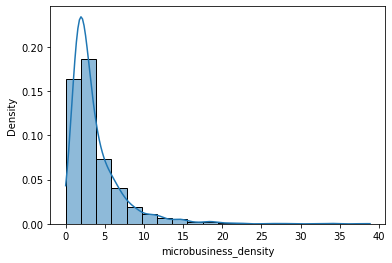

In [32]:
# plot the distribution of microbusiness density
sns.histplot(
    x="microbusiness_density",
    data=df_latest[df_latest["microbusiness_density"] < 40],
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.show()

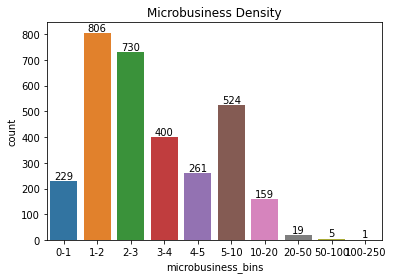

In [33]:
density_bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 250]
df_latest["microbusiness_bins"] = pd.cut(
    df_latest["microbusiness_density"],
    density_bins,
    labels=[
        f"{density_bins[i]}-{density_bins[i+1]}" for i in range(len(density_bins) - 1)
    ],
)
fig, ax = plt.subplots(1, 1)
sns.countplot(x="microbusiness_bins", data=df_latest, ax=ax)
plt.title("Microbusiness Density")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.show()

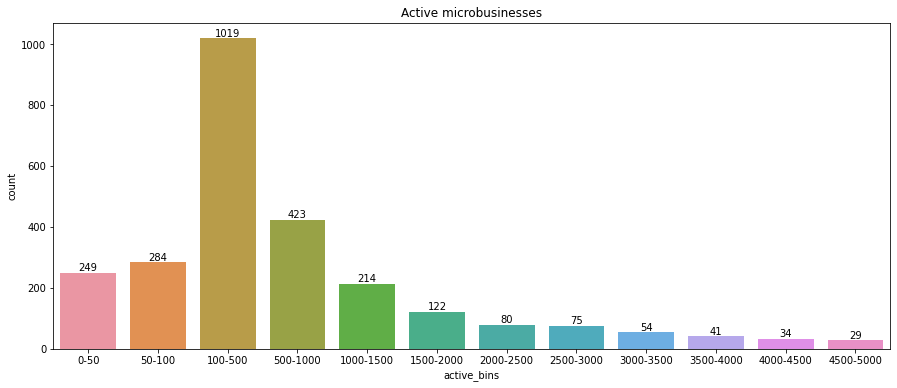

In [34]:
# create bins for the active column and plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
active_bins = [0, 50, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
df_latest["active_bins"] = pd.cut(
    df_latest["active"],
    active_bins,
    labels=[
        f"{active_bins[i]}-{active_bins[i+1]}" for i in range(len(active_bins) - 1)
    ],
)

sns.countplot(x="active_bins", data=df_latest, ax=ax)
plt.title("Active microbusinesses")
plt.bar_label(plt.gca().containers[0], fmt="%.0f")
plt.show()

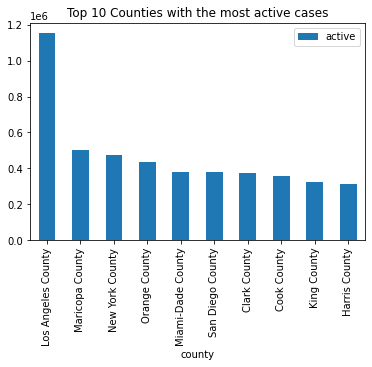

In [35]:
# visualize the top counties with the most active cases
df_latest.sort_values("active", ascending=False).head(10)[["county", "active"]].plot(
    kind="bar", x="county", y="active"
)
plt.title("Top 10 Counties with the most active cases")
plt.show()

In [36]:
df["pop_group_2020"] = pd.cut(
    df["POPESTIMATE2020"],
    bins=[0, 50000, 1000000, 100000000],
    labels=["small", "medium", "large"],
)

In [37]:
df.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,STNAME,CTYNAME,POPESTIMATE2020,POPESTIMATE2021,year,quarter,pop_group_2020
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,Alabama,Autauga County,58877,59095,2019,3,medium
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,Alabama,Autauga County,58877,59095,2019,3,medium
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,Alabama,Autauga County,58877,59095,2019,4,medium
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,4,medium
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,Alabama,Autauga County,58877,59095,2019,4,medium


## Persist

In [38]:
df.to_csv("../data/processed/county_data.csv", index=False)